Predicting classes using FastText

In [1]:
from os import getcwd, path
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = getcwd()

DATA_UTILS = path.join(BASE_PATH, 'data_utils.py')

exec(open(DATA_UTILS).read())

Load files necessary for inference to cache

In [2]:
from fastText import FastText
import json

MODEL_PATH = path.join(BASE_PATH, 'fasttext_model.bin')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

with open(CLASSES_FILE, 'r') as classes_file:
    classes_data = json.load(classes_file)

model = FastText.load_model(MODEL_PATH)

In [3]:
def interpret_netout(netout, classes=None):
    class_names, proba = netout
    for idx, class_name in enumerate(class_names):
        class_idx = int(class_name[len('__label__'):])
        if classes is not None:
            yield classes[class_idx], proba[idx]
        else:
            yield class_idx, proba[idx]

Test the loaded model:

In [4]:
list(interpret_netout(model.predict('My baby has a fever', k=5), classes_data))

[('Prenatal - Allergies - Passed on?', 0.8518627882003784),
 ('BabyNames', 0.025521930307149887),
 ('Baby Care - Bathing - Safety', 0.020848682150244713),
 ('Birth - Premature - NG Tube', 0.01742447353899479),
 ('Medical - Stomach Hard - Harm Baby', 0.01282634399831295)]

Try to run samples through the model to see false evaluations
This will help isolate the examples that make the model confused

In [5]:
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

result = [
    next(interpret_netout(model.predict(item.replace('\n', ' '), k=1))) 
    for item in X_data
]

y_train = np.array([
    classes_data.index(item)
    for item in y_data
], dtype='float32')
cell_text = []
for (idx, (result_idx, proba)) in list(enumerate(result)):
    if y_train[idx] != result_idx:
        cell_text.append([X_data[idx], y_data[idx], classes_data[result_idx], proba * 100])

Found 541 (accuracy: 94.73) misassigned examples. Showing the top 40


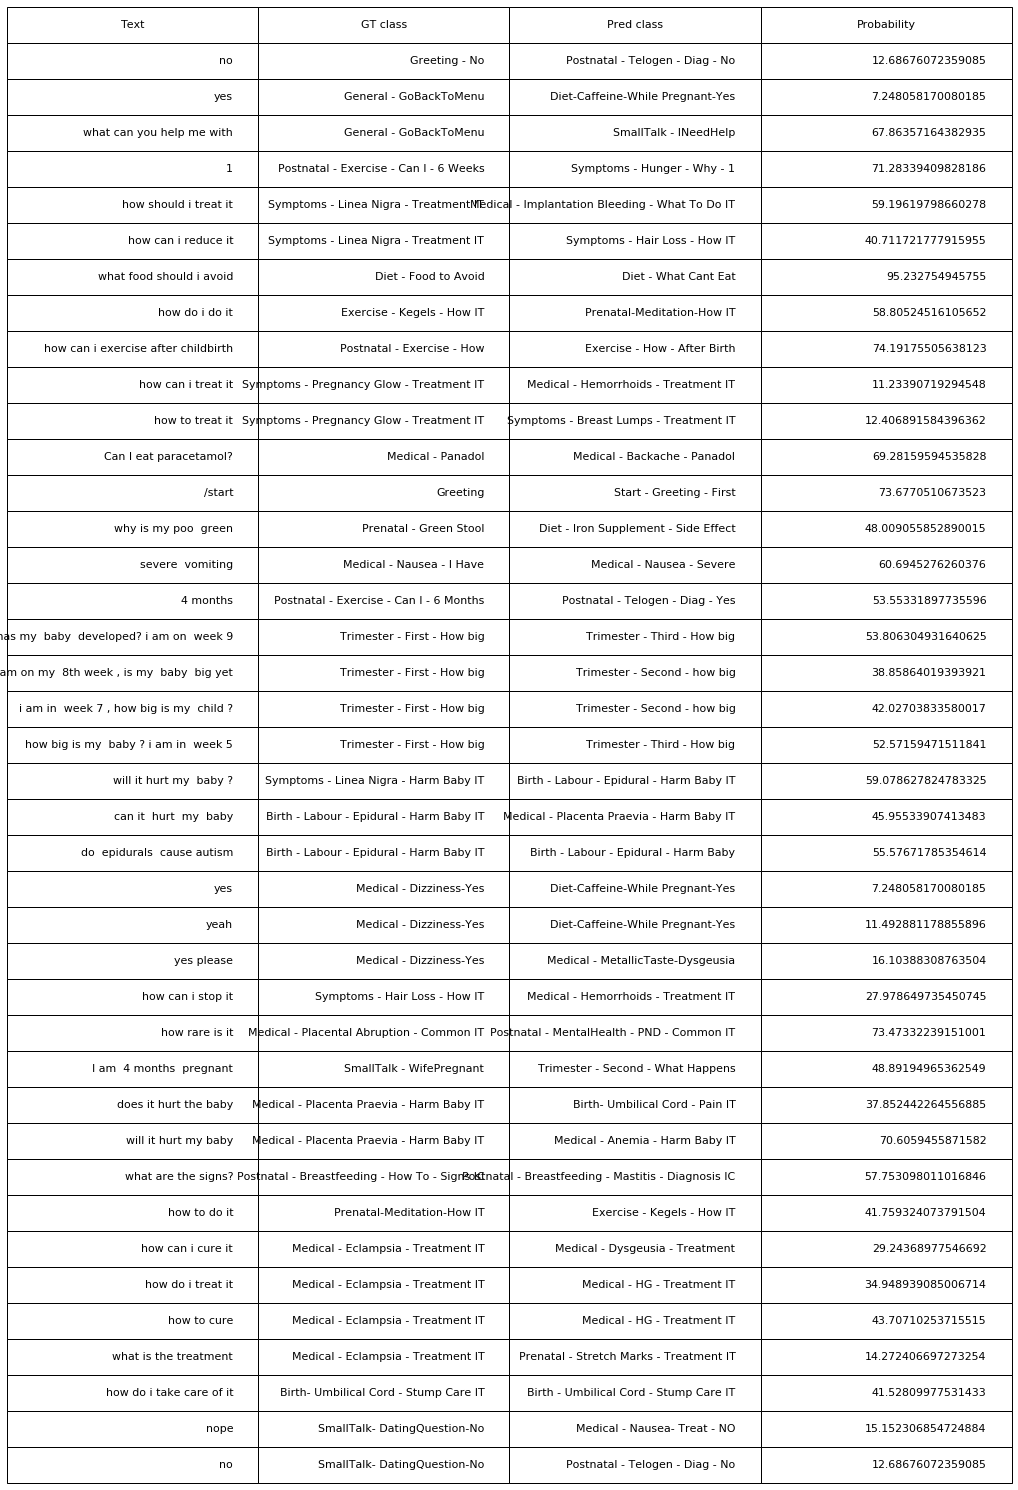

In [6]:
import matplotlib.pyplot as plt

print('Found %s (accuracy: %s) misassigned examples. Showing the top 40' \
    % (len(cell_text), 100 - round(len(cell_text) / len(X_data) * 100, 2)))

if len(cell_text) > 0:
    table = plt.table(cellText=cell_text[:40],
              colLabels=['Text', 'GT class', 'Pred class', 'Probability'],
              loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(3,3)
    plt.axis('off')
    plt.show()